# Demo for marker gene selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgb, ListedColormap, LinearSegmentedColormap

In [2]:
from scipy.stats import pmean

In [3]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

In [4]:
# Gene (families) and species (genomes)

## Algorithm

In [5]:
def greedy_power_mean_sample_final(data, k, p, pseudocount = 0.1, min_universality_genes = 1):
    """Iteratively select rows from a matrix such that the selection criterion by
    column is maximized.

    Parameters
    ----------
    data : ndarray of shape (2D)
        Input data matrix (gene by species).
    k : int
        Number of rows (genes) to select.
    p : float or str
        Exponent of generalized mean, or special values: "min" or "max".
    pseudocount : float, optional
        Pseudocount to add to each cell value.
    min_universality_genes : int, optional
        Minimum universality threshold.

    Returns
    -------
    ndarray (1D)
        Row indices selected in order.

    """
    # numbers of genes (n) and species (m)
    n, m = data.shape

    # matrix is empty
    if n == 0 or m == 0:
        raise ValueError('Matrix is empty!')

    # matrix contains only zeroes
    if (data == 0).all():
        raise ValueError('Matrix only contains 0\'s')

    if (data.sum(axis = 1) == min_universality_genes).all():
        raise ValueError(f'Matrix only contains genes present in less than {min_universality_genes}')

    if k >= n:
        raise ValueError(f'k should be smaller than {n}')

    # Add pseudocount
    data = data + pseudocount

    # cumulative gene counts
    counts = np.zeros(m, dtype = int)

    # gene indices in original data matrix
    indices = np.arange(n)

    # indices of selected genes
    selected = []

    # iteratively select k genes
    for i in range(k):

        # calculate counts after adding each gene
        sums_ = counts + data

        # select a gene that maximizes the power mean gene count per species, using the cumulative matrix
        if isinstance(p, int) or isinstance(p, np.int64): 
            choice = pmean(sums_, int(p), axis = 1).argmax()
        elif p == 'min':
            choice = sums_.min(axis = 1).argmax()
        elif p == 'max':
            choice = sums_.max(axis = 1).argmax()
        else:
            raise ValueError(f'Invalid p: {p}.')

        # append index of selected gene
        selected.append(indices[choice])

        # update per-species gene counts
        counts = sums_[choice]

        # remove selected gene from data matrix
        data = np.delete(data, choice, axis = 0)

        # remove selected gene from indices
        indices = np.delete(indices, choice)

    # return np.sort(np.array(selected))
    return np.array(selected)

## Simple case

Let us generate a matrix with all the possible configurations for S species. Because we only consider presence/absence, then the number of possible configurations (number of genes) is $2^S$.

For $S = 5$, the number of genes = $2^{5} = 32$

In [6]:
S = 5
G = 2 ** 5

In [7]:
data = np.array(np.meshgrid(*([0, 1],) * S)).T.reshape(-1, S)
data.shape

(32, 5)

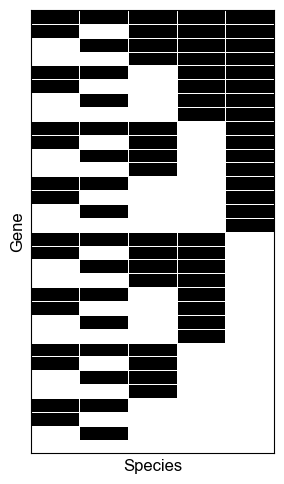

In [8]:
plt.figure(figsize=(3, 5))
plt.pcolormesh(data, cmap = 'binary', lw = 0.5, ec = 'white')
plt.xticks([])
plt.yticks([])
plt.xlabel('Species')
plt.ylabel('Gene')
plt.tight_layout()

Select $k$ markers with $p = 0$

In [9]:
k = 10
p = 0

In [10]:
select = greedy_power_mean_sample_final(data, k, p)
select

array([31, 15, 27, 23, 29, 30,  7, 25, 14, 19])

Number of markers per species

In [11]:
sums = data[select].sum(axis = 0)
sums

array([8, 8, 7, 7, 7])

In [12]:
cmapx = ListedColormap([(0, 0, 0, 0), (*to_rgb('crimson'), 0.5)])

In [13]:
shade = np.zeros(G, dtype=int)
shade[select] = 1
shade = np.tile(shade, (S, 1)).T

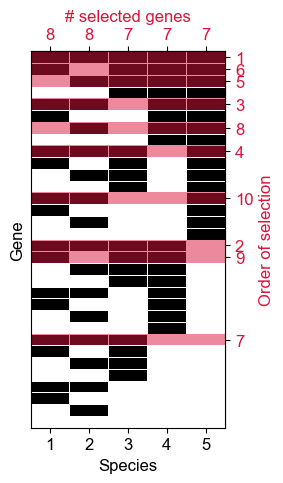

In [14]:
fig, ax = plt.subplots(figsize=(3, 5))

ax.pcolormesh(data, cmap = 'binary', lw = 0.5, ec = 'white')

ax.pcolormesh(shade, cmap = cmapx, lw = 0)

xrange = np.arange(S)
ax.set_xticks(xrange + 0.5, xrange + 1)
ax.set_xlabel('Species')

# yrange = np.arange(G)
# ax.set_yticks(yrange + 0.5, yrange + 1)
ax.set_yticks([])
ax.set_ylabel('Gene')

xax2 = ax.secondary_xaxis('top')
xax2.set_xticks(np.arange(S) + 0.5, sums, c = 'crimson');
xax2.set_xlabel('# selected genes', c = 'crimson')

yax2 = ax.secondary_yaxis('right')
yax2.set_yticks(select + 0.5, np.arange(k) + 1, c = 'crimson')
yax2.set_ylabel('Order of selection', c = 'crimson')

plt.tight_layout()
plt.savefig(f'figures/figure_1B.svg')

## Complex example

Random generator

In [15]:
rng = np.random.default_rng(seed = 0)

Specify the numbers of genes (_G_, rows) and species (_S_, columns), respectively

In [16]:
G = 50  # number of genes
S = 10  # number of species

**First**, simulate the presence/absence of each gene in each species.

Probability of a gene's presence per species. This roughly equals to the fraction of all genes found within each species. For simplicity, we sample the probabilities from a uniform distribution between 0.1 and 1.0.

In [17]:
probs = rng.uniform(low = 0.1, high = 1.0, size = S)
probs

array([0.67326552, 0.34280804, 0.13687617, 0.11487487, 0.83194322,
       0.92148002, 0.6459722 , 0.7565469 , 0.58926249, 0.94156518])

Use the probabilities to sample the presence/absence of each gene within each species.

In [18]:
data = [rng.choice([0, 1], size = G, p = [1 - x, x]) for x in probs]
data = np.vstack(data).T

In [19]:
labels = np.array([f'{label}' for label in range(S)])
genes = np.arange(G)

**Next**, simulate the number of copies of each gene within each species.

Maximum copy number. The actual copy number is sampled from a uniform distribution between 1 (minimum) and this number.

In [20]:
max_copies = 5

In [21]:
for i in range(G):
    gene = data[i, :]
    copies = rng.integers(low = 1, high = max_copies, size = len(gene.nonzero()[0]), endpoint = True)
    gene[gene > 0] = copies

Plot

In [22]:
cmap_copies = LinearSegmentedColormap.from_list('from_list', ['white', 'black'], max_copies + 1)

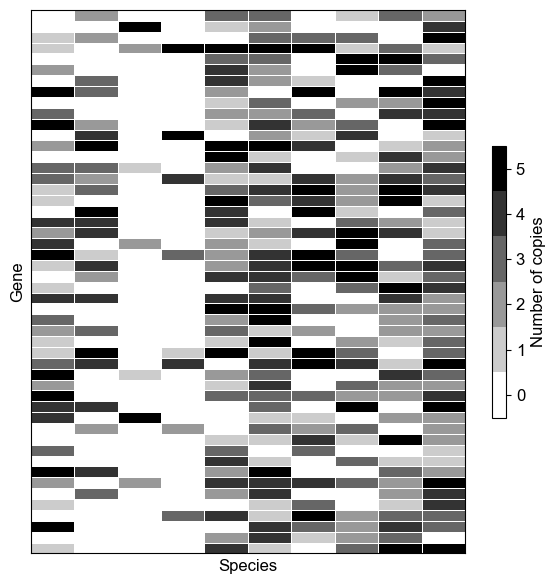

In [23]:
plt.figure(figsize = (6, 6))
plt.pcolormesh(data, vmin = -0.5, vmax = max_copies + 0.5, cmap = cmap_copies, lw = 0.5, ec = 'white')
plt.colorbar(label = 'Number of copies', shrink = 0.5)
plt.xticks([])
plt.yticks([])
plt.xlabel('Species')
plt.ylabel('Gene')
plt.tight_layout()
# plt.savefig('complex.svg')

Run the algorithm to select markers

In [24]:
k = 10

In [25]:
ps = [-40, -20, 0, 20, 40]

In [26]:
selects = {p: greedy_power_mean_sample_final(data, k, p) for p in ps}

Plot

In [27]:
shade_colors = ['mediumseagreen', 'dodgerblue', 'crimson', 'slateblue', 'orchid']

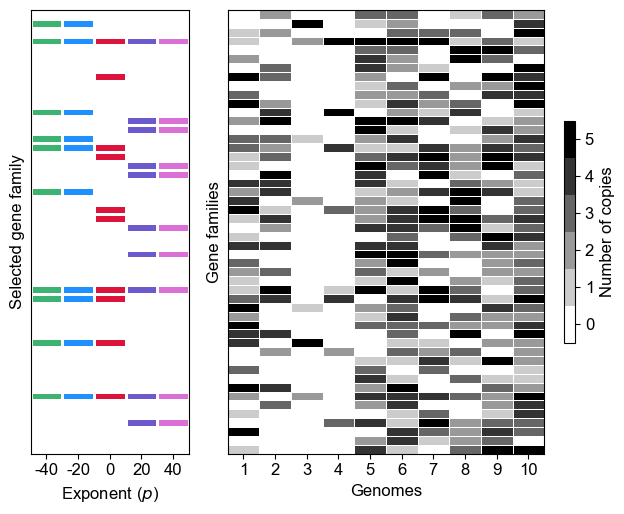

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (6.5, 5.3), width_ratios = (2, 5), sharey = True)
ax = axs[1]

im = ax.pcolormesh(data, vmin = -0.5, vmax = max_copies + 0.5, cmap = cmap_copies, lw = 0.5, ec = 'white')

fig.colorbar(im, ax = ax, label = 'Number of copies', shrink = 0.5)

xrange = np.arange(S)
ax.set_xticks(xrange + 0.5, xrange + 1)
ax.set_xlabel('Genomes')

yrange = np.arange(G)
ax.set_yticks([])
ax.set_ylabel('Gene families')

ax = axs[0]

for i, select in enumerate(selects.values()):
    shade = np.zeros(G, dtype=int)
    shade[select] = 1
    cmap_ = ListedColormap(['w', shade_colors[i]])
    ax.pcolormesh(np.array([i, i + 1]), np.arange(G + 1), shade.reshape(-1, 1), cmap = cmap_, ec = 'white', lw = 1)

ax.set_xticks(np.arange(len(selects)) + 0.5, selects.keys())
ax.set_xlabel('Exponent ($p$)')

ax.set_yticks([])
ax.set_ylabel('Selected gene family')

fig.tight_layout()
fig.savefig('./figures/figure_S2A.svg')